# [E-16] Movie SBR


라이브러리 가져오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## **Step 1. 데이터의 전처리**

---

**위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 `항목별 기본 분석, session length, session time, cleaning` 등의 작업을 진행합니다.  
특히, 이 데이터셋에서는 Session이 아닌 `UserID 단위`로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.**

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', 
                       header=None, usecols=[0, 1, 2, 3], 
                       names = ['UserId', 'ItemId', 'Rating', 'Time'],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, 
                       nrows=nrows)
    return data

data = load_data(train_path, None)

data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


pandas 출력 포맷팅

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [5]:
data.describe()

,UserId,ItemId,Rating,Time
count,1000209.00,1000209.00,1000209.00,1000209.00
mean,3024.51,1865.54,3.58,972243695.40
std,1728.41,1096.04,1.12,12152558.94
min,1.00,1.00,1.00,956703932.00
25%,1506.00,1030.00,3.00,965302637.00
50%,3070.00,1835.00,4.00,973018006.00
75%,4476.00,2770.00,4.00,975220939.00
max,6040.00,3952.00,5.00,1046454590.00


### 1.1 기본 분석 : 유저수, item값 확인

In [6]:
print("유저수 :", data['UserId'].nunique())
print("아이템수 :", data['ItemId'].nunique())

유저수 : 6040
아이템수 : 3706


### 1.2 userid length

userid의 크기 확인

In [7]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

userid의 통계값

In [8]:
user_length.describe()

count   6040.00
mean     165.60
std      192.75
min       20.00
25%       44.00
50%       96.00
75%      208.00
max     2314.00
dtype: float64

In [9]:
user_length.quantile(0.99)

906.659999999998

In [10]:
# 길이가 2314인 userid 확인하기
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


세션 길이 기준 하위 99%까지의 분포 누적합, 시각화

In [11]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

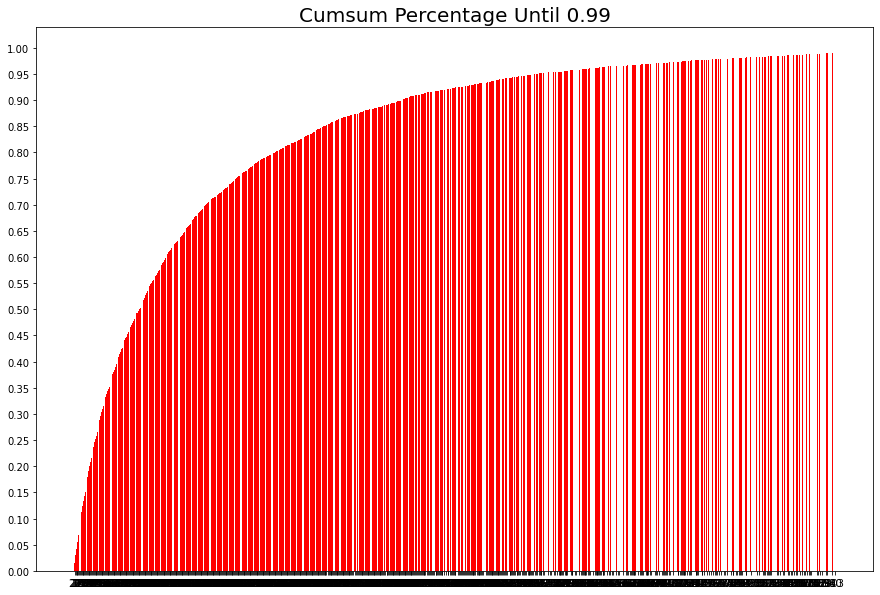

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

boxplot 그리기

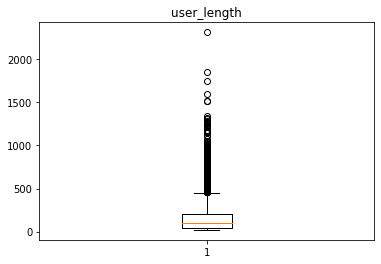

In [13]:
plt.boxplot(user_length)
plt.title('user_length')
plt.show()

### 1.3 time

In [14]:
# 일반적인 시간표현으로 변경
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [15]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

### 1.4 Cleaning

userid의 길이가 작은 데이터 제거 함수 구현

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

데이터 정리

In [19]:
data = cleanse_recursive(data, shortest=4, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.
Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### 2.1 Train / Valid / Test split

test-6개월, valid - 6개월, train - 나머지


In [20]:
data = data.sort_values(by=['Time'])

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [22]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

분리된 데이터 정보 보기

In [23]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978986
	 Users: 6038
	 Items: 3592
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12289
	 Users: 399
	 Items: 2624
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8820
	 Users: 339
	 Items: 2330
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



인덱싱

In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

데이터셋 pickle로 저장하기

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 2.2 SessionDataset

In [27]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [28]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999877,6040,1419,3,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999920,6040,213,5,2000-04-25 23:07:36,9


In [29]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978522, 978645, 978986], dtype=int32)

In [30]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

### 2.3 SessionDataLoader

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4


In [33]:
iter_ex = iter(tr_data_loader)

In [34]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


## Step 3. 모델 구성


### 3.1 Evaluation Metric

MRR, Recall 함수 구현

In [35]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3.2 Model Architecture

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

모델 만드는 함수

In [37]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

hyper-parameter 관리 Class

In [38]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

훈련 모델 설계

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다.  
실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

첫번째 모델 학습
- batch_size=256
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=10

In [41]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:10<00:57,  1.47s/it]


	 - Recall@20 epoch 1: 0.042969
	 - MRR@20    epoch 1: 0.008116



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.34s/it]


	 - Recall@20 epoch 2: 0.066964
	 - MRR@20    epoch 2: 0.014359



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.34s/it]


	 - Recall@20 epoch 3: 0.078683
	 - MRR@20    epoch 3: 0.015701



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]


	 - Recall@20 epoch 4: 0.085379
	 - MRR@20    epoch 4: 0.017336



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 5: 0.082589
	 - MRR@20    epoch 5: 0.018667



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.37s/it]


	 - Recall@20 epoch 6: 0.088728
	 - MRR@20    epoch 6: 0.019748



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.36s/it]


	 - Recall@20 epoch 7: 0.088170
	 - MRR@20    epoch 7: 0.021392



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 8: 0.087612
	 - MRR@20    epoch 8: 0.020506



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.37s/it]


	 - Recall@20 epoch 9: 0.089286
	 - MRR@20    epoch 9: 0.021429



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]

	 - Recall@20 epoch 10: 0.090960
	 - MRR@20    epoch 10: 0.021163



두번째 모델 학습
- batch_size=256
- hsz=100
- drop_rate=0.2
- lr=0.001
- epochs=10

In [42]:
args1 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model1 = create_model(args1)
train_model(model1, args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1108200   
_________________________________________________________________
dropout_1 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (256, 3592)               362792    
Total params: 1,470,992
Trainable params: 1,470,992
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:10<00:58,  1.51s/it]


	 - Recall@20 epoch 1: 0.056362
	 - MRR@20    epoch 1: 0.012778



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.38s/it]


	 - Recall@20 epoch 2: 0.074219
	 - MRR@20    epoch 2: 0.016362



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.38s/it]


	 - Recall@20 epoch 3: 0.078683
	 - MRR@20    epoch 3: 0.019070



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.35s/it]


	 - Recall@20 epoch 4: 0.090960
	 - MRR@20    epoch 4: 0.020209



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.38s/it]


	 - Recall@20 epoch 5: 0.093192
	 - MRR@20    epoch 5: 0.022051



Evaluation:  15%|█▌        | 7/46 [00:09<00:53,  1.38s/it]


	 - Recall@20 epoch 6: 0.092076
	 - MRR@20    epoch 6: 0.021577



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.34s/it]


	 - Recall@20 epoch 7: 0.092634
	 - MRR@20    epoch 7: 0.022711



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 8: 0.093750
	 - MRR@20    epoch 8: 0.022977



Evaluation:  15%|█▌        | 7/46 [00:09<00:54,  1.39s/it]


	 - Recall@20 epoch 9: 0.084263
	 - MRR@20    epoch 9: 0.021289



Evaluation:  15%|█▌        | 7/46 [00:10<00:56,  1.45s/it]

	 - Recall@20 epoch 10: 0.092076
	 - MRR@20    epoch 10: 0.020950



세번째 모델 학습
- batch_size=128
- hsz=100
- drop_rate=0.1
- lr=0.001
- epochs=10

In [43]:
args2 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1108200   
_________________________________________________________________
dropout_2 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 3592)               362792    
Total params: 1,470,992
Trainable params: 1,470,992
Non-trainable params: 0
_________________________________________________________________


Evaluation:  45%|████▍     | 41/92 [00:29<00:36,  1.40it/s]


	 - Recall@20 epoch 1: 0.088986
	 - MRR@20    epoch 1: 0.020177



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.44it/s]


	 - Recall@20 epoch 2: 0.101372
	 - MRR@20    epoch 2: 0.023444



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.45it/s]


	 - Recall@20 epoch 3: 0.108422
	 - MRR@20    epoch 3: 0.025394



Evaluation:  45%|████▍     | 41/92 [00:28<00:34,  1.46it/s]


	 - Recall@20 epoch 4: 0.108994
	 - MRR@20    epoch 4: 0.026336



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.45it/s]


	 - Recall@20 epoch 5: 0.112233
	 - MRR@20    epoch 5: 0.027644



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.43it/s]


	 - Recall@20 epoch 6: 0.113186
	 - MRR@20    epoch 6: 0.028566



Evaluation:  45%|████▍     | 41/92 [00:28<00:36,  1.41it/s]


	 - Recall@20 epoch 7: 0.112424
	 - MRR@20    epoch 7: 0.028211



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.45it/s]


	 - Recall@20 epoch 8: 0.108422
	 - MRR@20    epoch 8: 0.027639



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.43it/s]


	 - Recall@20 epoch 9: 0.108613
	 - MRR@20    epoch 9: 0.027811



Evaluation:  45%|████▍     | 41/92 [00:28<00:35,  1.43it/s]

	 - Recall@20 epoch 10: 0.108803
	 - MRR@20    epoch 10: 0.027065



네번째 모델 학습
- batch_size=64
- hsz=100
- drop_rate=0.2
- lr=0.001
- epochs=10

In [44]:
args3 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3592)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1108200   
_________________________________________________________________
dropout_3 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 3592)                362792    
Total params: 1,470,992
Trainable params: 1,470,992
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.73it/s]


	 - Recall@20 epoch 1: 0.112525
	 - MRR@20    epoch 1: 0.025188



Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.72it/s]


	 - Recall@20 epoch 2: 0.120968
	 - MRR@20    epoch 2: 0.029899



Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.71it/s]


	 - Recall@20 epoch 3: 0.124244
	 - MRR@20    epoch 3: 0.031403



Evaluation:  67%|██████▋   | 124/185 [00:44<00:22,  2.77it/s]


	 - Recall@20 epoch 4: 0.125756
	 - MRR@20    epoch 4: 0.032751



Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.72it/s]


	 - Recall@20 epoch 5: 0.125504
	 - MRR@20    epoch 5: 0.032867



Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.73it/s]


	 - Recall@20 epoch 6: 0.127646
	 - MRR@20    epoch 6: 0.033249



Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.75it/s]


	 - Recall@20 epoch 7: 0.125126
	 - MRR@20    epoch 7: 0.032849



Evaluation:  67%|██████▋   | 124/185 [00:45<00:22,  2.73it/s]


	 - Recall@20 epoch 8: 0.126008
	 - MRR@20    epoch 8: 0.033050



Evaluation:  67%|██████▋   | 124/185 [00:47<00:23,  2.63it/s]


	 - Recall@20 epoch 9: 0.126260
	 - MRR@20    epoch 9: 0.032988



Evaluation:  67%|██████▋   | 124/185 [00:44<00:22,  2.77it/s]

	 - Recall@20 epoch 10: 0.125630
	 - MRR@20    epoch 10: 0.032901



### **Step 5. 모델 테스트**

---

**미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.**

첫번째 모델 평가
- batch_size=256
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=10

In [45]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:42,  1.39s/it]

	 - Recall@20: 0.085938
	 - MRR@20: 0.018114



두번째 모델 평가
- batch_size=256, hsz=100, drop_rate=0.2, lr=0.001, epochs=10
- hsz 2배로 늘였으나 Recall은 그댈로 MRR이 조금 높아지는 정도

In [46]:
test_model(model1, args1, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:41,  1.32s/it]

	 - Recall@20: 0.085938
	 - MRR@20: 0.020381



세번째 모델 평가
- batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=10
- batch_size를 반으로 죽였더니 확연히 차이가 나는 것은 아니지만 조금 좋아진건가?

In [47]:
test_model(model2, args2, test)

Evaluation:  36%|███▋      | 24/66 [00:16<00:28,  1.47it/s]

	 - Recall@20: 0.127279
	 - MRR@20: 0.032662



네번째 모델 평가
- batch_size=64, hsz=100, drop_rate=0.2, lr=0.001, epochs=10
- 이게 좋아진건지...

In [48]:
test_model(model3, args3, test)

Evaluation:  59%|█████▉    | 78/132 [00:28<00:19,  2.78it/s]

	 - Recall@20: 0.137821
	 - MRR@20: 0.037799



## 회고
- 이번 프로젝트에서 **어려웠던 점**
    - 모든 것을 노드 따라서 했는 데, 훈련 중 멈춰서 당황
    -  batch_size를 조정하니 훈련이 되었음..
    - 아마 Session-Parallel Mini-Batches 때문이라고 짐작만 함
- 프로젝트를 진행하면서 **알아낸 점**
    - GRU4REC 모델에 대해 조금..
- 프로젝트를 진행하면서 **모호한 점**
    - recall, rmm을 가지고 평가를 하라고 하는 데, 정확히 어떤 것이 좋은 건지 모르겠다.
    - recall의 값이 높아지는 것이 좋은 것인가?? -> 찾아보니 precision과 같이 봐야 한다고 하는 데
    - 논문을 읽어도 잘 모르겠다...
    

실력이 늘어나는 것이 아니라 복붙하는 손만 바빠진 것 같아서.. 슬프네요...😭😭😭